In [9]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

#loading the provided data
file_path = './WristMotion.csv'
data = pd.read_csv(file_path)
print(data.head())
print(data.info())


                  time  seconds_elapsed  rotationRateX  rotationRateY  \
0  1719102681279387400         0.079387       0.262128       0.584997   
1  1719102681289442300         0.089442       0.225379       0.574750   
2  1719102681299496400         0.099496       0.171646       0.587262   
3  1719102681309551400         0.109551       0.173631       0.616396   
4  1719102681319605200         0.119605       0.183095       0.631882   

   rotationRateZ  gravityX  gravityY  gravityZ  accelerationX  accelerationY  \
0       1.059689 -0.187712 -0.490008 -0.851267      -0.048189       0.054904   
1       1.040166 -0.187870 -0.490174 -0.851137      -0.036465       0.037522   
2       1.044665 -0.188041 -0.489920 -0.851245      -0.043679       0.034735   
3       1.067783 -0.188100 -0.489417 -0.851522      -0.039333       0.035651   
4       1.061081 -0.187965 -0.488926 -0.851833      -0.037850       0.029774   

   accelerationZ  quaternionW  quaternionX  quaternionY   quaternionZ  
0      -

In [11]:
import numpy as np

# Define a function to generate synthetic data
def generate_synthetic_data(num_samples, seq_length):
    time = np.arange(num_samples)
    seconds_elapsed = time / 100.0  # Assuming 100 Hz sampling rate

    # Simulate sensor data
    rotation_rate = np.random.normal(0, 1, (num_samples, 3))
    gravity = np.random.normal(0, 1, (num_samples, 3))
    acceleration = np.random.normal(0, 1, (num_samples, 3))
    quaternion = np.random.normal(0, 1, (num_samples, 4))

    # Combine into a DataFrame
    synthetic_data = pd.DataFrame({
        'time': time,
        'seconds_elapsed': seconds_elapsed,
        'rotationRateX': rotation_rate[:, 0],
        'rotationRateY': rotation_rate[:, 1],
        'rotationRateZ': rotation_rate[:, 2],
        'gravityX': gravity[:, 0],
        'gravityY': gravity[:, 1],
        'gravityZ': gravity[:, 2],
        'accelerationX': acceleration[:, 0],
        'accelerationY': acceleration[:, 1],
        'accelerationZ': acceleration[:, 2],
        'quaternionW': quaternion[:, 0],
        'quaternionX': quaternion[:, 1],
        'quaternionY': quaternion[:, 2],
        'quaternionZ': quaternion[:, 3]
    })

    # Simulate initial GPS location and compute positions
    initial_latitude = 37.7749
    initial_longitude = -122.4194
    initial_altitude = 0

    # Assuming small movements and converting to approximate meters
    delta_latitude = np.cumsum(acceleration[:, 0]) * 0.00001
    delta_longitude = np.cumsum(acceleration[:, 1]) * 0.00001
    delta_altitude = np.cumsum(acceleration[:, 2]) * 0.1  # Assuming z-axis is altitude

    synthetic_data['latitude'] = initial_latitude + delta_latitude
    synthetic_data['longitude'] = initial_longitude + delta_longitude
    synthetic_data['altitude'] = initial_altitude + delta_altitude

    return synthetic_data

# Generate synthetic data
synthetic_data = generate_synthetic_data(10000, 50)
print(synthetic_data.head())


   time  seconds_elapsed  rotationRateX  rotationRateY  rotationRateZ  \
0     0             0.00      -2.502506       1.696238       0.456311   
1     1             0.01      -0.959918       0.103460       0.747168   
2     2             0.02      -0.652626      -0.152940      -1.313167   
3     3             0.03       2.120027       1.586265      -0.148374   
4     4             0.04      -0.978163       0.589259      -0.321226   

   gravityX  gravityY  gravityZ  accelerationX  accelerationY  accelerationZ  \
0 -2.596141 -0.257863 -0.120146       0.041191      -0.619783      -0.409252   
1 -2.008715  1.069435 -0.839415      -0.591997      -1.552138      -0.974627   
2 -0.988087  0.601132  2.629792       0.187841      -0.324934      -0.040472   
3  0.806620 -1.279871 -1.056934      -2.346687      -0.215139       0.633499   
4  0.680030 -0.426697  1.017615      -1.033742      -0.737147       0.510356   

   quaternionW  quaternionX  quaternionY  quaternionZ   latitude   longitude  \


In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the data
scaler = MinMaxScaler()
sensor_data = synthetic_data.iloc[:, 2:14]
normalized_sensor_data = scaler.fit_transform(sensor_data)

# Create sequences
def create_sequences(data, target, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_sequences(normalized_sensor_data, synthetic_data[['latitude', 'longitude', 'altitude']].values, seq_length)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))  # Predicting latitude, longitude, and altitude
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 5137.3926 - val_loss: 4566.3994
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 4458.2207 - val_loss: 4153.5283
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 4064.5586 - val_loss: 3795.8857
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 3716.4912 - val_loss: 3473.6086
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 3399.0320 - val_loss: 3179.9878
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 3116.0469 - val_loss: 2911.0745
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 2851.0435 - val_loss: 2663.9734
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 2615.6936 - val_loss: 2436.3984
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 2383.8521 - val_loss: 2226.2444
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 2183.0227 - val_loss: 2032.0626
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 1997.2415 - val_lo

In [14]:
# Evaluate the model
val_loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0658
Validation Loss: 5.994516372680664


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


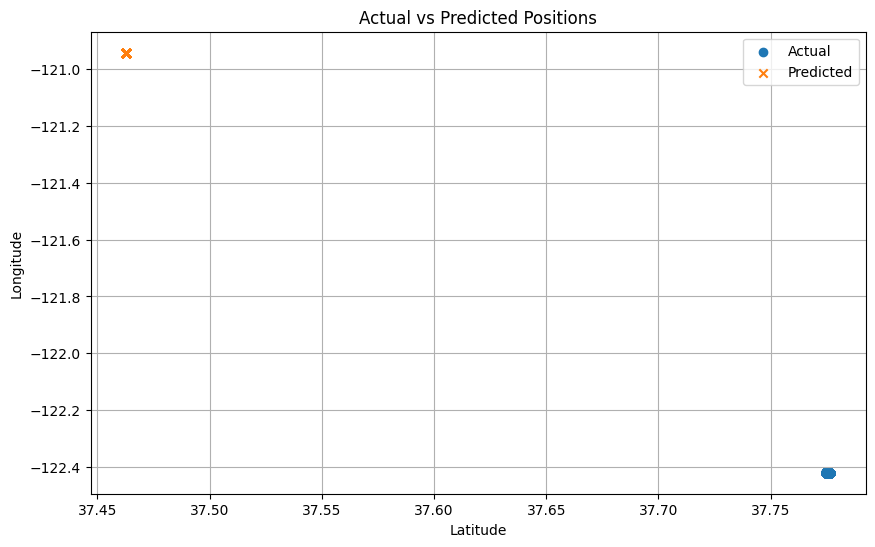

In [15]:
# Predict positions on the validation set
y_pred = model.predict(X_val)

# Plot the actual vs predicted positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val[:, 0], y_val[:, 1], label='Actual', marker='o')
plt.scatter(y_pred[:, 0], y_pred[:, 1], label='Predicted', marker='x')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.title('Actual vs Predicted Positions')
plt.grid(True)
plt.show()


In [16]:
# Save the model
model.save('swimmer_position_model.h5')
